Task 2-  The goal is to process this dataset from raw counts to biologically interpretable cell type clusters, following the major steps of the Scanpy pipeline.

First,installing all necessary packages here

In [11]:
!pip install scanpy
!pip install anndata
!pip install igraph
!pip install celltypist
!pip install decoupler

In [12]:
import scanpy as sc
import anndata as ad
import pandas as pd
import decoupler as dc

In [13]:
!wget wget -O result.txt 'http://www.ensembl.org/biomart/martservice?query=<?xml version="1.0" encoding="UTF-8"?><!DOCTYPE Query><Query  virtualSchemaName = "default" formatter = "CSV" header = "0" uniqueRows = "0" count = "" datasetConfigVersion = "0.6" ><Dataset name = "hsapiens_gene_ensembl" interface = "default" ><Attribute name = "ensembl_gene_id" /><Attribute name = "external_gene_name" /></Dataset></Query>'


#this downloads the table of genes directly from ensemble this is not the dataset, remember! More on why we do this step later on

--2025-12-02 03:46:02--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2025-12-02 03:46:02--  http://www.ensembl.org/biomart/martservice?query=%3C?xml%20version=%221.0%22%20encoding=%22UTF-8%22?%3E%3C!DOCTYPE%20Query%3E%3CQuery%20%20virtualSchemaName%20=%20%22default%22%20formatter%20=%20%22CSV%22%20header%20=%20%220%22%20uniqueRows%20=%20%220%22%20count%20=%20%22%22%20datasetConfigVersion%20=%20%220.6%22%20%3E%3CDataset%20name%20=%20%22hsapiens_gene_ensembl%22%20interface%20=%20%22default%22%20%3E%3CAttribute%20name%20=%20%22ensembl_gene_id%22%20/%3E%3CAttribute%20name%20=%20%22external_gene_name%22%20/%3E%3C/Dataset%3E%3C/Query%3E
Resolving www.ensembl.org (www.ensembl.org)... 193.62.193.83
Connecting to www.ensembl.org (www.ensembl.org)|193.62.193.83|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘result.txt’

result.txt              [      <=>      

In [14]:
import pandas as pd

ensembl_var = pd.read_csv('/content/result.txt', header = None)

ensembl_var.columns = ['ensembl_gene_id', 'gene_name']

ensembl_var.head(3)

,ensembl_gene_id,gene_name
0,ENSG00000210049,MT-TF
1,ENSG00000211459,MT-RNR1
2,ENSG00000210077,MT-TV


In [15]:
print( ensembl_var.shape)

#This is just to confirm if Ensemble gene IDs have downloaded or not

(86369, 2)


OmniPath is a comprehensive resource for molecular networks. The decoupler library uses it to access various curated biological resources, including databases of cell type markers. We are adding the cell type markers in this step basically

PanglaoDB is one such database, specifically focused on single-cell RNA sequencing data, providing cell type markers for various tissues and organisms. We are were retrieving a list of called marker genes.

Why do we do this? These marker genes are essential for cell type annotation.  identify what type of cell each cell is. By looking at which marker genes are highly expressed in a given cluster of cells, you can assign a likely cell type identity

In [16]:
# Query Omnipath and get PanglaoDB
markers = dc.op.resource(name="PanglaoDB", organism="human")

# Keep canonical cell type markers alone
#markers = markers[markers["canonical_marker"]]

# Remove duplicated entries
markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]

#Format because dc only accepts cell_type and genesymbol

markers = markers.rename(columns={"cell_type": "source", "genesymbol": "target"})
markers = markers[["source", "target"]]


markers.head()


,source,target
,,
0,Hepatocytes,A1CF
1,Germ cells,A2APA5
2,Bergmann glia,A2M
3,Mast cells,A3FIN4
4,Mast cells,A4GALT


In [17]:
#correct target to ensemble
markers = markers.merge(ensembl_var, left_on="target", right_on="gene_name", how="left")
markers = markers.drop(columns=["target"])
# Remove duplicated entries
markers = markers[~markers.duplicated(["source", "ensembl_gene_id"])]

#Format because dc only accepts cell_type and genesymbol
markers = markers.rename(columns={"source": "source", "ensembl_gene_id": "target"})

markers = markers[["source", "target"]]
markers = markers.dropna()

markers.head()

,source,target
0,Hepatocytes,ENSG00000148584
2,Bergmann glia,ENSG00000175899
4,Mast cells,ENSG00000128274
6,Interneurons,ENSG00000115977
7,Neurons,ENSG00000115977


We have done so far only gene symbols → Ensembl IDs.  

 The dataset from CZI uses ensemble gene ids. This is in contradiction to what decoupler expects.

 Decoupler needs to match genes between dataset that we need to analyse and The marker gene list from the reference.  Decoupler expects the gene identifiers in the markers DataFrame to match exactly with the gene identifiers in your adata.var_names

In [18]:
#now we load the dataset

!wget https://github.com/josoga2/sc/raw/refs/heads/main/bone_marrow.h5ad

bone_marrow_adata = sc.read('/content/bone_marrow.h5ad')

print (bone_marrow_adata)

print (bone_marrow_adata.shape)

--2025-12-02 03:46:07--  https://github.com/josoga2/sc/raw/refs/heads/main/bone_marrow.h5ad
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/josoga2/sc/refs/heads/main/bone_marrow.h5ad [following]
--2025-12-02 03:46:07--  https://media.githubusercontent.com/media/josoga2/sc/refs/heads/main/bone_marrow.h5ad
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 354509549 (338M) [application/octet-stream]
Saving to: ‘bone_marrow.h5ad’

bone_marrow.h5ad    100%[===================>] 338.09M  51.4MB/s    in 6.8s    

2025-12-02 03:46:14 (49.6 MB/s) - ‘bone_marrow.h5ad’ saved [354509549/35450

In [19]:

"""to check OBS- which contains cells (observations)metadata,when we load it we can see some observation made related to the cell"""
bone_marrow_adata.obs.head()


,disease stage,treatment,timepoint,Dataset,sample,disease_original,disease_general,COVID-19 Condition,Lineage,Cell.group,...,is_primary_data,suspension_type,tissue_type,assay,disease,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
index,,,,,,,,,,,,,,,,,,,,,
Guo-AAACCTGAGAGCTTCT-2,severe,400 mg Tocilizumab at day 1,day 1,Guo et al._Nature Communication,Guo_P1-day1-rep2,COVID-19 Severe,COVID-19 Severe/Late stage/Vent,severe,Myeloid,CD14+ Monocyte,...,False,cell,tissue,10x 3' v2,COVID-19,male,blood,unknown,39-year-old stage,2P)e%zgsv_
Guo-AAACCTGAGAGGTTGC-7,remission,400 mg Tocilizumab at day 1,day 7,Guo et al._Nature Communication,Guo_P2-day7,COVID-19 Mild/Remission,COVID-19 Remission,remission,Lymphoid_T/NK,CD8+ T cell,...,False,cell,tissue,10x 3' v2,COVID-19,male,blood,unknown,78-year-old stage,Lv&N1yD6*0
Guo-AAACCTGAGATACACA-3,remission,400 mg Tocilizumab at day 1,day 5,Guo et al._Nature Communication,Guo_P1-day5-rep1,COVID-19 Mild/Remission,COVID-19 Remission,remission,Lymphoid_T/NK,CD4+ T cell,...,False,cell,tissue,10x 3' v2,COVID-19,male,blood,unknown,39-year-old stage,DZ>`^5OH2o
Guo-AAACCTGAGCGATTCT-1,severe,400 mg Tocilizumab at day 1,day 1,Guo et al._Nature Communication,Guo_P1-day1-rep1,COVID-19 Severe,COVID-19 Severe/Late stage/Vent,severe,Lymphoid_T/NK,CD8+ T cell,...,False,cell,tissue,10x 3' v2,COVID-19,male,blood,unknown,39-year-old stage,J4$QmqEgvX
Guo-AAACCTGAGTGAAGAG-3,remission,400 mg Tocilizumab at day 1,day 5,Guo et al._Nature Communication,Guo_P1-day5-rep1,COVID-19 Mild/Remission,COVID-19 Remission,remission,Lymphoid_T/NK,CD4+ T cell,...,False,cell,tissue,10x 3' v2,COVID-19,male,blood,unknown,39-year-old stage,Y&7u#&E`-T


In [20]:
"""To check var meta data, which contains genes (variables)- you can see meta data , and some realted info to gene- like no of cells, type of gene etc """
bone_marrow_adata.var.head()

,n_cells,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type
ENSG00000161920,927,False,MED11,NCBITaxon:9606,gene,754,protein_coding
ENSG00000122335,429,False,SERAC1,NCBITaxon:9606,gene,2683,protein_coding
ENSG00000175548,149,False,ALG10B,NCBITaxon:9606,gene,1773,protein_coding
ENSG00000100330,426,False,MTMR3,NCBITaxon:9606,gene,634,protein_coding
ENSG00000176340,7171,False,COX8A,NCBITaxon:9606,gene,494,protein_coding


In [21]:
bone_marrow_adata.to_df()

,ENSG00000161920,ENSG00000122335,ENSG00000175548,ENSG00000100330,ENSG00000176340,ENSG00000179846,ENSG00000204860,ENSG00000172260,ENSG00000141424,ENSG00000164512,...,ENSG00000164114,ENSG00000151702,ENSG00000224578,ENSG00000138756,ENSG00000111052,ENSG00000176946,ENSG00000150456,ENSG00000284934,ENSG00000261842,ENSG00000260456
index,,,,,,,,,,,,,,,,,,,,,
Guo-AAACCTGAGAGCTTCT-2,0.0,0.000000,0.0,0.0,9.436466,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Guo-AAACCTGAGAGGTTGC-7,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,8.817776,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Guo-AAACCTGAGATACACA-3,0.0,8.651494,0.0,0.0,8.651494,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Guo-AAACCTGAGCGATTCT-1,0.0,0.000000,0.0,0.0,8.858533,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Guo-AAACCTGAGTGAAGAG-3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Guo-TTTGTCAGTTTCGCTC-4,0.0,0.000000,0.0,0.0,8.389465,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Guo-TTTGTCATCAGAGACG-7,0.0,0.000000,0.0,0.0,9.931639,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Guo-TTTGTCATCAGATAAG-4,0.0,0.000000,0.0,0.0,10.009642,0.0,0.0,0.0,0.000000,0.0,...,0.0,9.01104,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Removing duplicates from var and obs- this is just a good practice for older datasets, nothing else

In [22]:
bone_marrow_adata.var_names_make_unique()
bone_marrow_adata.obs_names_make_unique()


After just filtering out the duplicates, in the next steps, we will remove  contamination.

Cells with a high proportion of mitochondrial reads (say >10–20%) are likely stressed, apoptotic, or poorly captured.

Think about this- we extract those cells into a micrifludic device, there is a good chance that it may some stress


 you can find ribosome everywhere, why would you need them when you study cell specific ?


Instead of true cell populations, high HB signal often represents ambient RNA contamination from lysed red blood cells


In [23]:
bone_marrow_adata.var['MT'] = bone_marrow_adata.var['feature_name'].str.startswith("MT-")
bone_marrow_adata.var['RIBO'] = bone_marrow_adata.var['feature_name'].str.startswith(("RPS", "RPL"))
bone_marrow_adata.var['HB'] = bone_marrow_adata.var['feature_name'].str.contains("^HB[^(P)]", regex=True)

Now, just a small peek into MT genes ,ribo and HB

In [24]:
mt_genes=bone_marrow_adata.var[bone_marrow_adata.var['MT']]
mt_genes





,n_cells,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type,MT,RIBO,HB
ENSG00000228253,2270,False,MT-ATP8,NCBITaxon:9606,gene,207,protein_coding,True,False,False
ENSG00000198899,15626,False,MT-ATP6,NCBITaxon:9606,gene,681,protein_coding,True,False,False
ENSG00000198763,15561,False,MT-ND2,NCBITaxon:9606,gene,1042,protein_coding,True,False,False
ENSG00000198886,15656,False,MT-ND4,NCBITaxon:9606,gene,1378,protein_coding,True,False,False
ENSG00000198804,15656,False,MT-CO1,NCBITaxon:9606,gene,1542,protein_coding,True,False,False
ENSG00000198695,4611,False,MT-ND6,NCBITaxon:9606,gene,525,protein_coding,True,False,False
ENSG00000212907,6575,False,MT-ND4L,NCBITaxon:9606,gene,297,protein_coding,True,False,False
ENSG00000198888,14520,False,MT-ND1,NCBITaxon:9606,gene,956,protein_coding,True,False,False
ENSG00000198712,15669,False,MT-CO2,NCBITaxon:9606,gene,684,protein_coding,True,False,False
ENSG00000198727,15393,False,MT-CYB,NCBITaxon:9606,gene,1141,protein_coding,True,False,False


In [25]:
ribo_genes=bone_marrow_adata.var[bone_marrow_adata.var['RIBO']]
ribo_genes



,n_cells,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type,MT,RIBO,HB
ENSG00000197958,14752,False,RPL12,NCBITaxon:9606,gene,634,protein_coding,False,True,False
ENSG00000117676,2019,False,RPS6KA1,NCBITaxon:9606,gene,586,protein_coding,False,True,False
ENSG00000122026,15386,False,RPL21,NCBITaxon:9606,gene,628,protein_coding,False,True,False
ENSG00000174444,13230,False,RPL4,NCBITaxon:9606,gene,671,protein_coding,False,True,False
ENSG00000089157,13079,False,RPLP0,NCBITaxon:9606,gene,792,protein_coding,False,True,False
...,...,...,...,...,...,...,...,...,...,...
ENSG00000171863,14465,False,RPS7,NCBITaxon:9606,gene,707,protein_coding,False,True,False
ENSG00000147403,15417,False,RPL10,NCBITaxon:9606,gene,775,protein_coding,False,True,False
ENSG00000071242,82,False,RPS6KA2,NCBITaxon:9606,gene,817,protein_coding,False,True,False
ENSG00000114391,13854,False,RPL24,NCBITaxon:9606,gene,812,protein_coding,False,True,False


In [26]:


hb_genes=bone_marrow_adata.var[bone_marrow_adata.var['HB']]
hb_genes

,n_cells,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type,MT,RIBO,HB
ENSG00000086506,73,False,HBQ1,NCBITaxon:9606,gene,528,protein_coding,False,False,True
ENSG00000112339,1266,False,HBS1L,NCBITaxon:9606,gene,1290,protein_coding,False,False,True
ENSG00000196565,95,False,HBG2,NCBITaxon:9606,gene,586,protein_coding,False,False,True
ENSG00000113070,94,False,HBEGF,NCBITaxon:9606,gene,1230,protein_coding,False,False,True
ENSG00000223609,108,False,HBD,NCBITaxon:9606,gene,566,protein_coding,False,False,True
ENSG00000188536,3172,False,HBA2,NCBITaxon:9606,gene,544,protein_coding,False,False,True
ENSG00000244734,4679,False,HBB,NCBITaxon:9606,gene,618,protein_coding,False,False,True
ENSG00000206172,2302,False,HBA1,NCBITaxon:9606,gene,540,protein_coding,False,False,True
ENSG00000206177,21,False,HBM,NCBITaxon:9606,gene,592,protein_coding,False,False,True
ENSG00000213931,6,False,HBE1,NCBITaxon:9606,gene,913,protein_coding,False,False,True


Now, we will remove these from the dataset- we have just seen them, for later analysis, we can directly come here.

pp is the preprocessing from scanpy

this step is generating key statistical summaries for each cell regarding its content of mitochondrial, ribosomal, and hemoglobin gene expression. This information is vital for identifying and potentially filtering out low-quality cells (e.g., dead or stressed cells with high mitochondrial content, or red blood cell contamination indicated by high hemoglobin gene expression).

qc_vars=["MT", 'RIBO', 'HB']- categories to process.
The total count of reads mapping to genes in that category per cell.
The percentage of reads mapping to genes in that category per cell.
inplace=True: This means that the calculated quality control metrics will be added directly

In [27]:
sc.pp.calculate_qc_metrics(
    bone_marrow_adata, qc_vars=["MT", 'RIBO', 'HB'], inplace=True, log1p=True
)

Lets take a look at it- first with var

In [28]:
bone_marrow_adata.var.head()

,n_cells,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type,MT,RIBO,HB,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
ENSG00000161920,927,False,MED11,NCBITaxon:9606,gene,754,protein_coding,False,False,False,885,0.502831,0.407351,94.013394,7433.353516,8.913867
ENSG00000122335,429,False,SERAC1,NCBITaxon:9606,gene,2683,protein_coding,False,False,False,405,0.231814,0.208488,97.260367,3426.911377,8.139707
ENSG00000175548,149,False,ALG10B,NCBITaxon:9606,gene,1773,protein_coding,False,False,False,142,0.082084,0.078889,99.039437,1213.443970,7.102042
ENSG00000100330,426,False,MTMR3,NCBITaxon:9606,gene,634,protein_coding,False,False,False,404,0.227307,0.204822,97.267131,3360.278564,8.120077
ENSG00000176340,7171,False,COX8A,NCBITaxon:9606,gene,494,protein_coding,False,False,False,6898,4.277597,1.663471,53.338294,63235.750000,11.054641


Look at Ribo, MT and HB- it is false, showing that it is not there

In [29]:
bone_marrow_adata.obs.head()



,disease stage,treatment,timepoint,Dataset,sample,disease_original,disease_general,COVID-19 Condition,Lineage,Cell.group,...,pct_counts_in_top_500_genes,total_counts_MT,log1p_total_counts_MT,pct_counts_MT,total_counts_RIBO,log1p_total_counts_RIBO,pct_counts_RIBO,total_counts_HB,log1p_total_counts_HB,pct_counts_HB
index,,,,,,,,,,,,,,,,,,,,,
Guo-AAACCTGAGAGCTTCT-2,severe,400 mg Tocilizumab at day 1,day 1,Guo et al._Nature Communication,Guo_P1-day1-rep2,COVID-19 Severe,COVID-19 Severe/Late stage/Vent,severe,Myeloid,CD14+ Monocyte,...,40.537370,138.356339,4.937034,1.154665,879.968079,6.781022,7.343850,0.000000,0.000000,0.000000
Guo-AAACCTGAGAGGTTGC-7,remission,400 mg Tocilizumab at day 1,day 7,Guo et al._Nature Communication,Guo_P2-day7,COVID-19 Mild/Remission,COVID-19 Remission,remission,Lymphoid_T/NK,CD8+ T cell,...,57.850376,113.859787,4.743712,1.350507,914.212402,6.819156,10.843602,0.000000,0.000000,0.000000
Guo-AAACCTGAGATACACA-3,remission,400 mg Tocilizumab at day 1,day 5,Guo et al._Nature Communication,Guo_P1-day5-rep1,COVID-19 Mild/Remission,COVID-19 Remission,remission,Lymphoid_T/NK,CD4+ T cell,...,59.749640,125.068520,4.836825,1.543431,952.813843,6.860468,11.758374,18.301193,2.960167,0.225849
Guo-AAACCTGAGCGATTCT-1,severe,400 mg Tocilizumab at day 1,day 1,Guo et al._Nature Communication,Guo_P1-day1-rep1,COVID-19 Severe,COVID-19 Severe/Late stage/Vent,severe,Lymphoid_T/NK,CD8+ T cell,...,56.156243,103.474380,4.648942,1.182754,924.013672,6.829809,10.561848,0.000000,0.000000,0.000000
Guo-AAACCTGAGTGAAGAG-3,remission,400 mg Tocilizumab at day 1,day 5,Guo et al._Nature Communication,Guo_P1-day5-rep1,COVID-19 Mild/Remission,COVID-19 Remission,remission,Lymphoid_T/NK,CD4+ T cell,...,100.000121,138.531082,4.938287,2.870118,850.272156,6.746732,17.616129,0.000000,0.000000,0.000000


We will move on to violin plot to visualise outliers and in general how they are distributed. The data for the plots are obtained from .obs of this anndata frame

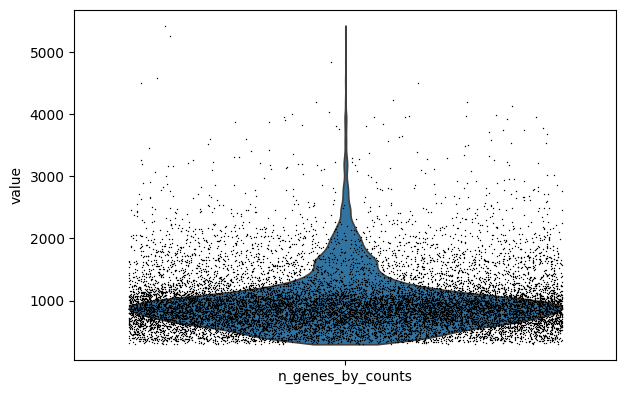

In [30]:
#N genes by count
sc.pl.violin(
    bone_marrow_adata,
    ["n_genes_by_counts"],
    jitter=0.4,
    multi_panel=False,
)

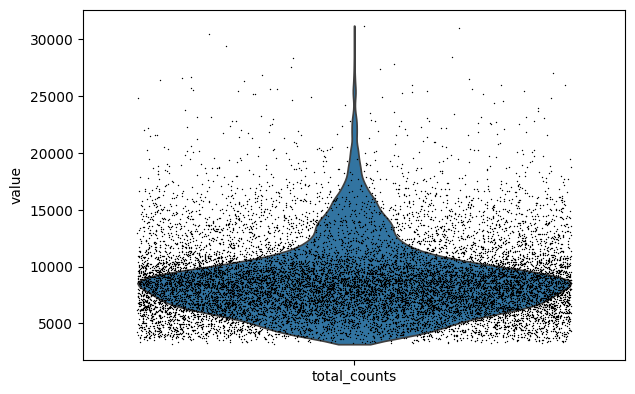

In [31]:
#Moving on to violin plots,first- the number of genes expressed in each cell
sc.pl.violin(
    bone_marrow_adata,
    ["total_counts"],
    jitter=0.4,
    multi_panel=False,
)

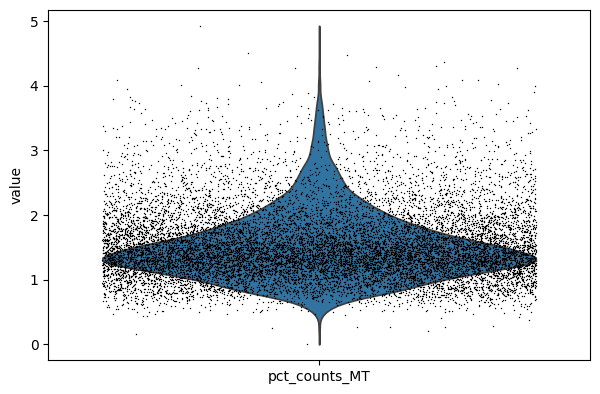

In [32]:
#mitochondrial genes

sc.pl.violin(
    bone_marrow_adata,
    ["pct_counts_MT"],
    jitter=0.4,
    multi_panel=False,
)

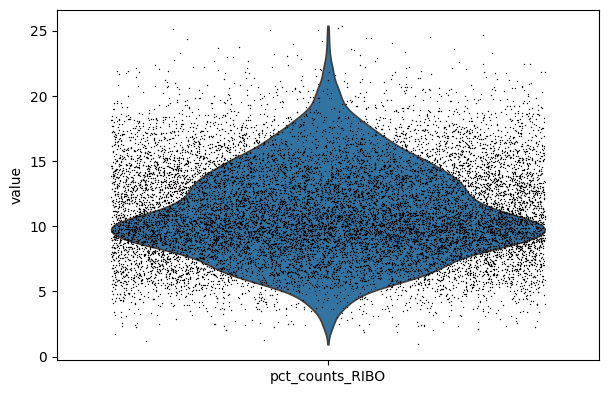

In [33]:
#and the ribosomal genes
sc.pl.violin(
    bone_marrow_adata,
    ["pct_counts_RIBO"],
    jitter=0.4,
    multi_panel=False,
)

Now we will make scatter plots, whiel violin shows realtionship between one , but scatter plot help in identifying the relationship between 2 of them.

it is good
seeing relationships between TWO metrics
finding cells that break expected patterns
understanding WHY cells are outliers

meanwhile violin plots wont be able to say relationships between metrics

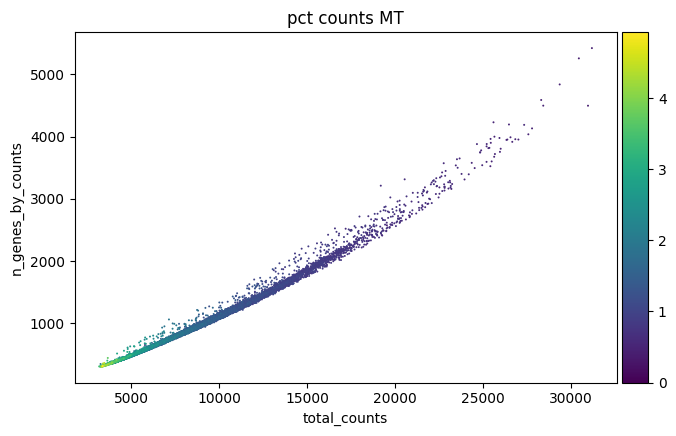

In [34]:
sc.pl.scatter(bone_marrow_adata, "total_counts", "n_genes_by_counts", color="pct_counts_MT")

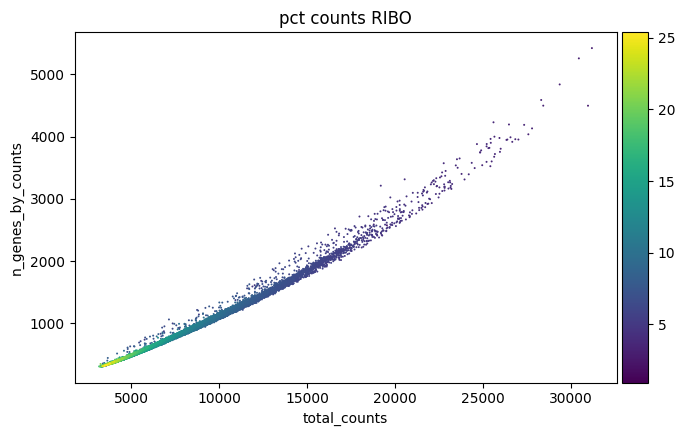

In [35]:
sc.pl.scatter(bone_marrow_adata, "total_counts", "n_genes_by_counts", color="pct_counts_RIBO")

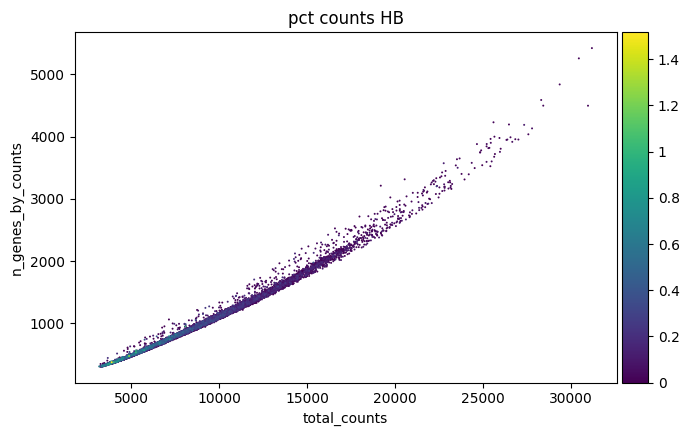

In [36]:
sc.pl.scatter(bone_marrow_adata, "total_counts", "n_genes_by_counts", color="pct_counts_HB")

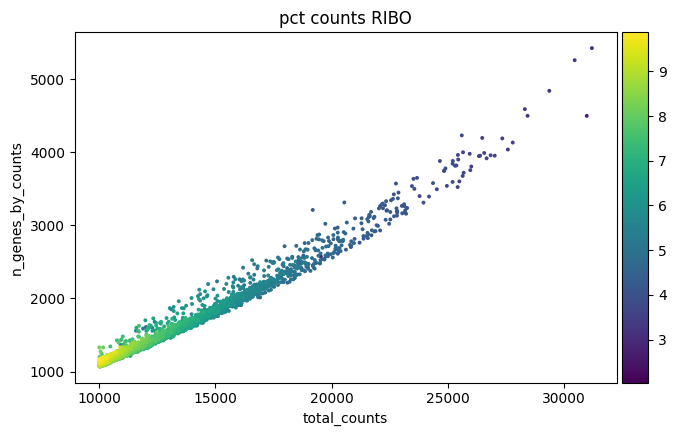

In [37]:
bone_marrow_adata = bone_marrow_adata[
    (bone_marrow_adata.obs['total_counts'] >= 10000) &
    (bone_marrow_adata.obs['n_genes_by_counts'] >= 1000) &
    (bone_marrow_adata.obs['pct_counts_RIBO'] < 10),
    :
]
sc.pl.scatter(bone_marrow_adata, "total_counts", "n_genes_by_counts", color="pct_counts_RIBO")

In [38]:
#doublet detection
##Identifying doublets is crucial as they can lead to misclassifications or
##distortions in downstream analysis steps

sc.pp.scrublet(bone_marrow_adata)

/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_scrublet/__init__.py:295: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["doublet_score"] = scrubbed["obs"]["doublet_score"]


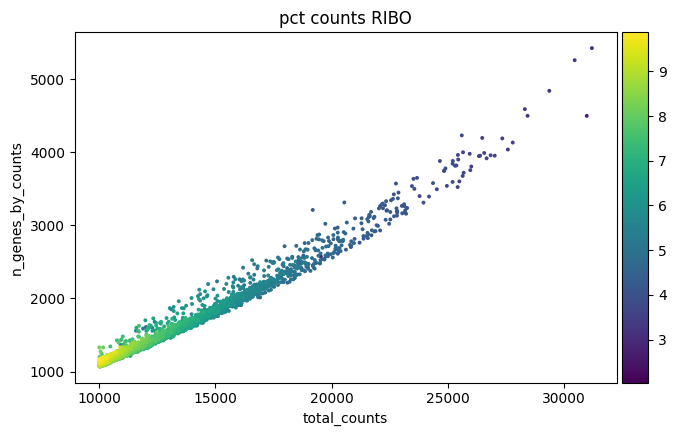

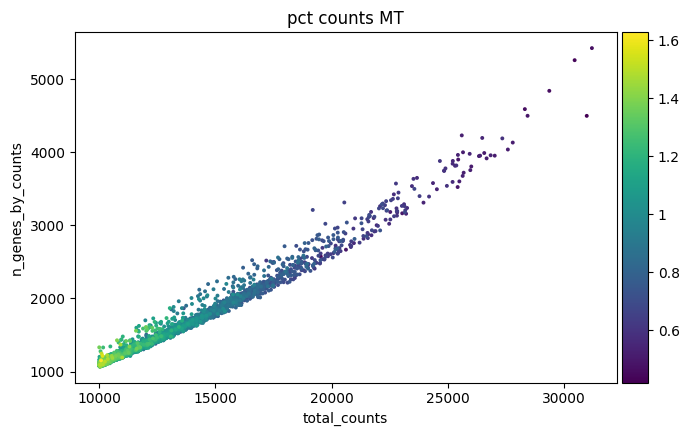

In [39]:
sc.pl.scatter(bone_marrow_adata, "total_counts", "n_genes_by_counts", color="pct_counts_RIBO")
sc.pl.scatter(bone_marrow_adata, "total_counts", "n_genes_by_counts", color="pct_counts_MT")

Moving on to Normalisation, we do normalisation because some samples may be sequenced at more depth, so we do that to adjusts for sequencing depth differences between cells. Here, we scale counts so each cell has the same total expression level.



In [40]:
# Save a copy of the data
bone_marrow_adata.layers["counts"] = bone_marrow_adata.X.copy()

In [41]:
# Normalizing to median total counts
sc.pp.normalize_total(bone_marrow_adata)
# Logarithmize the data
sc.pp.log1p(bone_marrow_adata)

In [42]:
#Feature selection
#selecting the top 1000 most variable genes
sc.pp.highly_variable_genes(bone_marrow_adata, n_top_genes=1000)

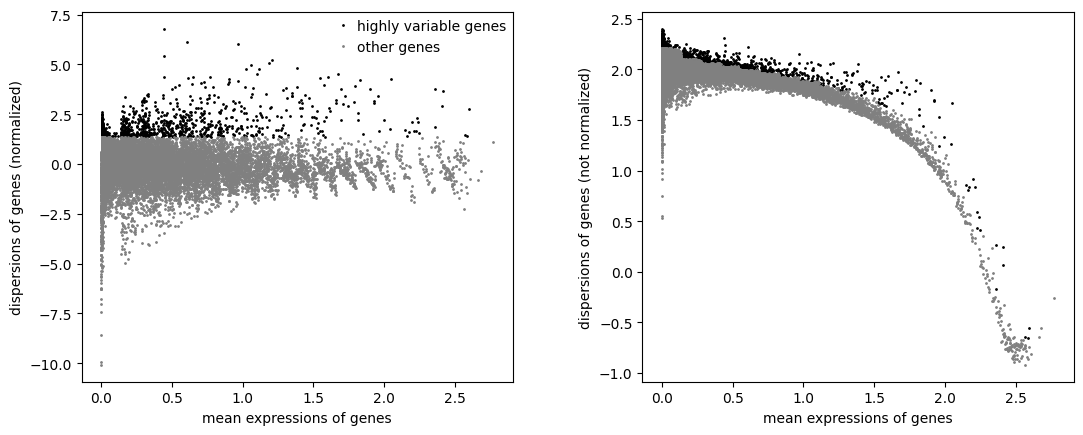

In [43]:
sc.pl.highly_variable_genes(bone_marrow_adata)


Now continuing with Dimensionality reduction
to reduce data complexity and highlight key variation patterns.
PCA compresses this high-dimensional data into a smaller set of features (typically 30–50 components) that summarize the key biological and technical variation across cells.

Remember: you have ~2,000 highly variable genes in your dataset. Each gene is like a dimension.Imagine this scenario:

You want to plot your cells to see which ones are similar
But you can't plot 2,000 dimensions on a screen!
You need to compress the data down to 2-3 dimensions you can visualize
The challenge: How do you compress 2,000 dimensions without losing the important patterns?PCA's answer: Find the directions where cells differ the most, and keep those.

In [44]:
sc.tl.pca(bone_marrow_adata)


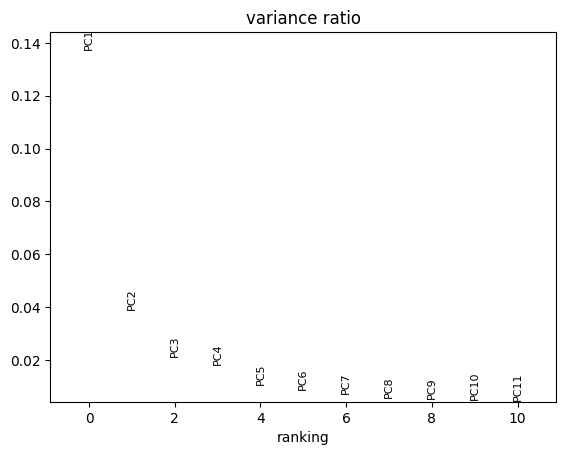

In [45]:
sc.pl.pca_variance_ratio(bone_marrow_adata, n_pcs=10, log=False)

PC1 = 14%
This means: "If I could only draw ONE line through my data to capture the most variation, it would explain 14% of all the differences between cells."
Why only 14%? Because cells are complex!

They don't all differ in just ONE way
There are multiple cell types, multiple states, multiple sources of variation
It takes MANY directions to capture all that complexity

PC2 = 4%
The second-best direction only captures 4%. Why the big drop?

The MAIN source of variation was already captured by PC1
What's left is smaller, more subtle patterns

PC3, PC4, PC5... decreasing
Each additional PC captures progressively less because:

You've already captured the major patterns
What remains are subtler biological signals
Eventually, just random noise

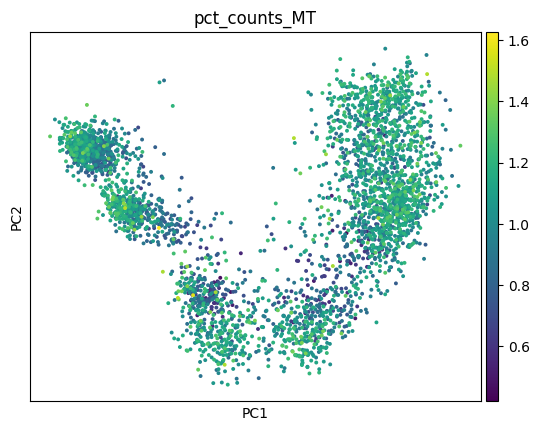

In [46]:
sc.pl.pca(
    bone_marrow_adata,
    color=["pct_counts_MT"]
)

Are those three clusters formed because of BIOLOGY or because of CELL QUALITY?"
 We can observe this because we see

✓ No clear gradient along PC1 (x-axis)

Colors are mixed left-to-right
Not separating by mito% horizontally

✓ No clear gradient along PC2 (y-axis)

Colors are mixed top-to-bottom
Not separating by mito% vertically

✓ Random color distribution throughout

Each of the three visible clusters has a mix of colors
Teal/green dominates (which means most cells have low-moderate mito%)

✓ Very few yellow/bright cells

Yellow would be high mito% (1.5-1.6%)
You barely see any, which means your filtering worked well
Most cells are in the 0.4-1.2% range (healthy!)

this shows that - PCA has worked and is independent of cell quality.

Those three visible clusters you see are likely:

Different cell types (T cells, B cells, monocytes, etc.)
Different cell states (activated vs resting)
Real biological variation

They are NOT clustering by:

Healthy vs dying cells
High quality vs low quality
Technical artifacts

We see clusters, but what do they mean ? for that we  compute the neighborhood graph of cells using the PCA representation of the data matrix.

so we start from pca , then we do PCA plot of MT as a qc check. The next step is to see which set of cells are similar-
in a sample,we may have thousands of cells spread across 0-50 dimensional space (PCs)
We need to group simialr cells to togetehr to cluster, so thats why we do clustering.

why group similar cells and the cluster them ?
n your PCA space:
* Cells that are close together = similar gene expression patterns
* Cells that are far apart = different gene expression patterns

In [47]:
sc.pp.neighbors(bone_marrow_adata)

In [48]:
sc.tl.umap(bone_marrow_adata)

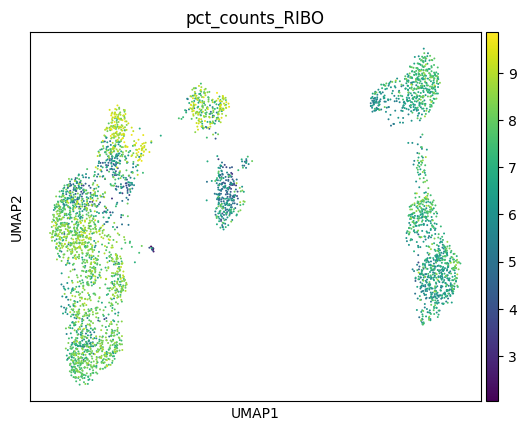

In [49]:
sc.pl.umap(
    bone_marrow_adata,
    color=["pct_counts_RIBO"],
    size=8,
)

 In nearest neighbors - Built a graph in 30D PC space
Can't visualize a graph in 30 dimensions!
Clustering

Found communities in that 30D graph
Assigned cluster labels
But we still can't SEE the full structure!
thats why UMAP!

ribosomes- here because its just. a qc check again

clustering by communities.

##Clustering by communities in single-cell RNA-seq is the process of grouping cells that show similar expression profiles — essentially, discovering putative cell types or states.

## Once PCA compresses your data into a manageable set of dimensions, clustering algorithms like Leiden operate on a graph-based representation of cell–cell relationships.

## Usually used for cell type detection

# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets





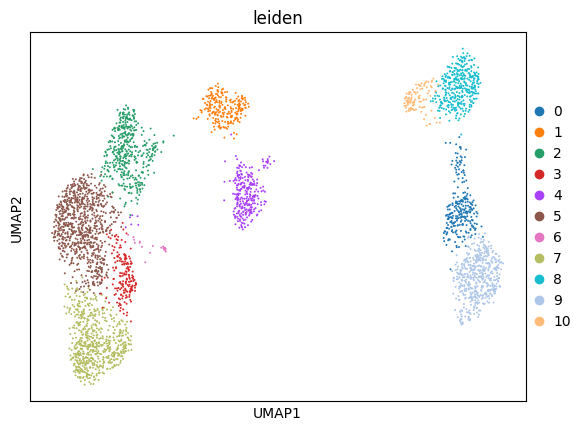

In [50]:
sc.tl.leiden(bone_marrow_adata, flavor="igraph", n_iterations=2)
sc.pl.umap(
    bone_marrow_adata,
    color=["leiden"],
    size=8,
)

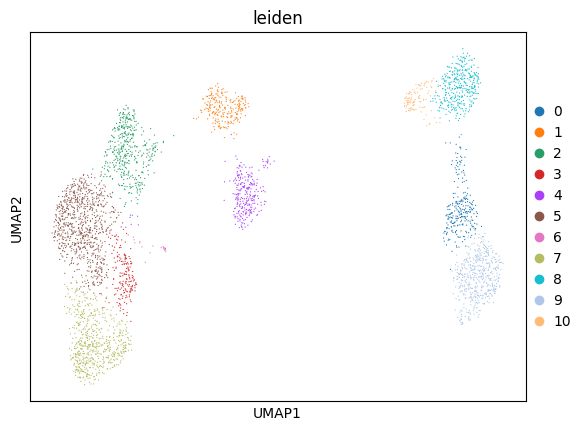

In [51]:
sc.pl.umap(
    bone_marrow_adata,
    color=["leiden"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
    ncols = 1
)

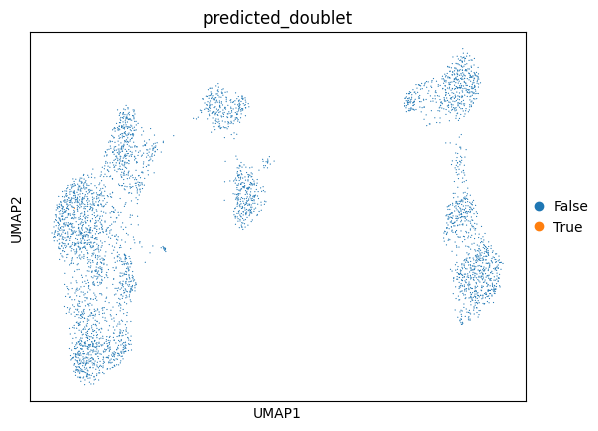

In [52]:
sc.pl.umap(
   bone_marrow_adata,
    color=[ "predicted_doublet"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
    ncols = 1
)

In [53]:
sc.tl.leiden(bone_marrow_adata, flavor="igraph", n_iterations=2, key_added="leiden_res0_02", resolution=0.02)
sc.tl.leiden(bone_marrow_adata, flavor="igraph", n_iterations=2, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(bone_marrow_adata, flavor="igraph", n_iterations=2, key_added="leiden_res2", resolution=2)

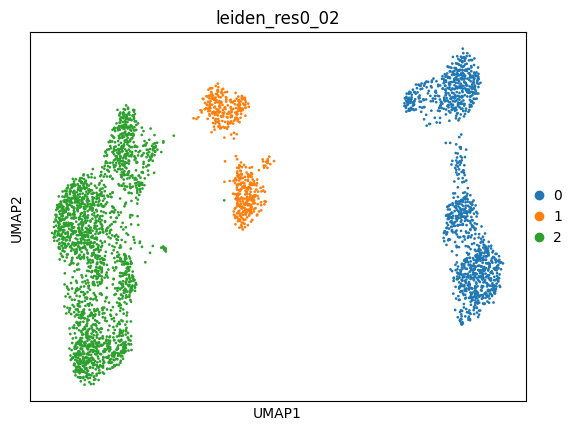

In [54]:
sc.pl.umap(
    bone_marrow_adata,
    color=["leiden_res0_02"],
    # increase horizontal space between panels
    wspace=0.5,
    size=15,
    ncols = 1
)

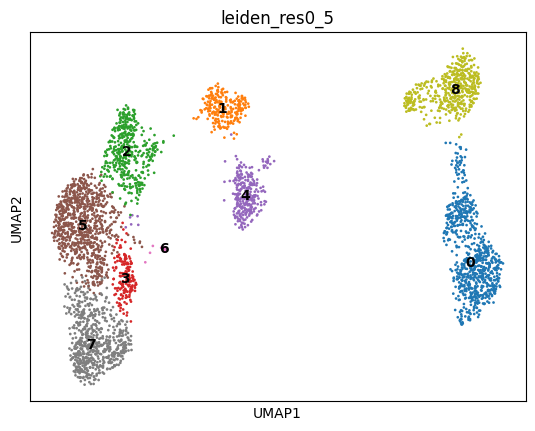

In [55]:
sc.pl.umap(
   bone_marrow_adata,
    color=["leiden_res0_5"],
    # increase horizontal space between panels
    wspace=0.5,
    size=15,
    ncols = 1,
    legend_loc="on data"
)

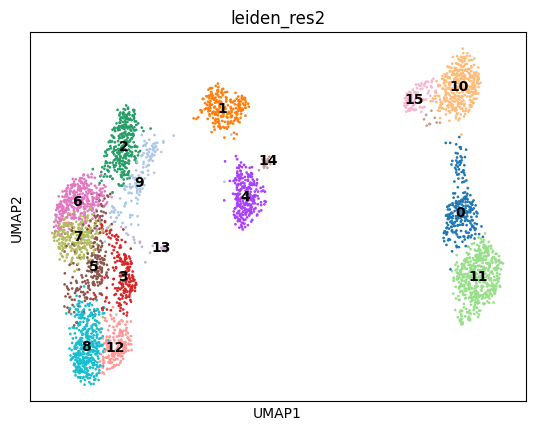

In [56]:
sc.pl.umap(
   bone_marrow_adata,
    color=["leiden_res2"],
    # increase horizontal space between panels
    wspace=0.5,
    size=15,
    ncols = 1,
    legend_loc="on data"
)

Moving on to Annotation so far we have just the clustering, we need to label them process of assigning biological meaning—like cell type or functional state—to each cluster found after Leiden clustering.

Traditionally, this relies on manual marker gene inspection: you identify top genes per cluster and match them to known markers.
we need decoupler, we alrady have downloaded decoupler, so we will get into it directly. else you need to downlaod decoupler

In [57]:
# Query Omnipath and get PanglaoDB
markers = dc.op.resource(name="PanglaoDB", organism="human")

# Keep canonical cell type markers alone
#markers = markers[markers["canonical_marker"]]

# Remove duplicated entries
markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]

#Format because dc only accepts cell_type and genesymbol

markers = markers.rename(columns={"cell_type": "source", "genesymbol": "target"})
markers = markers[["source", "target"]]


markers.head()

,source,target
,,
0,Hepatocytes,A1CF
1,Germ cells,A2APA5
2,Bergmann glia,A2M
3,Mast cells,A3FIN4
4,Mast cells,A4GALT


In [58]:
#correct target to ensemble
markers = markers.merge(ensembl_var, left_on="target", right_on="gene_name", how="left")
markers = markers.drop(columns=["target"])
# Remove duplicated entries
markers = markers[~markers.duplicated(["source", "ensembl_gene_id"])]

#Format because dc only accepts cell_type and genesymbol
markers = markers.rename(columns={"source": "source", "ensembl_gene_id": "target"})

markers = markers[["source", "target"]]
markers = markers.dropna()

markers.head()

,source,target
0,Hepatocytes,ENSG00000148584
2,Bergmann glia,ENSG00000175899
4,Mast cells,ENSG00000128274
6,Interneurons,ENSG00000115977
7,Neurons,ENSG00000115977


In [59]:
#load the gene expression matrix into dc

dc.mt.ulm(data=bone_marrow_adata,
          net=markers,
          tmin = 3)

In [60]:
#retrieve the score for each cell type

score = dc.pp.get_obsm(bone_marrow_adata, key="score_ulm")
score

AnnData object with n_obs × n_vars = 3799 × 163
    obs: 'disease stage', 'treatment', 'timepoint', 'Dataset', 'sample', 'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage', 'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts', 'percent_mito', 'tissue_original', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'total_counts_RIBO', 'log1p_total_counts_RIBO', 'p

In [61]:
bone_marrow_adata.obsm["score_ulm"].head()

,Acinar cells,Adipocyte progenitor cells,Adipocytes,Adrenergic neurons,Airway goblet cells,Alpha cells,Alveolar macrophages,Anterior pituitary gland cells,Astrocytes,B cells,...,Tanycytes,Taste receptor cells,Thymocytes,Transient cells,Trigeminal neurons,Trophoblast cells,Tuft cells,Undefined placental cells,Urothelial cells,Vascular smooth muscle cells
index,,,,,,,,,,,,,,,,,,,,,
Guo-AAACCTGAGAGCTTCT-2,0.855169,-0.987891,0.479640,-0.595589,-1.031851,0.720424,5.122934,-0.238927,0.201640,1.092008,...,0.675057,0.287271,-0.554400,0.490393,-0.946670,-0.368951,3.096875,-0.787965,-0.787965,-0.515779
Guo-AAACCTGCACACCGCA-4,-1.077648,-0.922728,-1.026615,-0.556304,1.217856,0.918198,-0.499492,-0.057535,1.486590,8.230731,...,-0.735990,0.424851,2.061567,1.602569,0.607073,-0.230699,1.176356,-0.735990,-0.735990,-0.481758
Guo-AAACCTGGTTCAGGCC-4,0.463877,-0.068835,-0.730657,1.012158,-0.158820,-1.246730,-0.721475,-0.391401,-0.241141,0.515913,...,-0.851460,-0.965527,0.693562,0.279612,-1.118816,0.279612,0.687369,-0.851460,-0.851460,-0.557340
Guo-AAACCTGTCAAGGTAA-2,-1.144371,-0.979857,-0.339418,-0.590745,-1.023460,0.835467,0.255072,-1.144371,-0.588692,5.391222,...,-0.781557,0.311735,2.692890,-0.346447,0.411516,0.612581,0.937561,-0.781557,-0.781557,-0.511584
Guo-AAACCTGTCCTGCCAT-5,-0.930015,-1.384222,-0.373935,-0.834518,-0.573139,0.519189,-0.783196,1.129638,-0.267909,6.553886,...,0.905469,-0.365784,1.918937,0.260289,-0.731107,-0.342862,-0.258464,-0.026776,-0.099295,-0.722689


In [62]:
bone_marrow_adata.obsm["score_ulm"].columns

Index(['Acinar cells', 'Adipocyte progenitor cells', 'Adipocytes',
       'Adrenergic neurons', 'Airway goblet cells', 'Alpha cells',
       'Alveolar macrophages', 'Anterior pituitary gland cells', 'Astrocytes',
       'B cells',
       ...
       'Tanycytes', 'Taste receptor cells', 'Thymocytes', 'Transient cells',
       'Trigeminal neurons', 'Trophoblast cells', 'Tuft cells',
       'Undefined placental cells', 'Urothelial cells',
       'Vascular smooth muscle cells'],
      dtype='object', length=163)

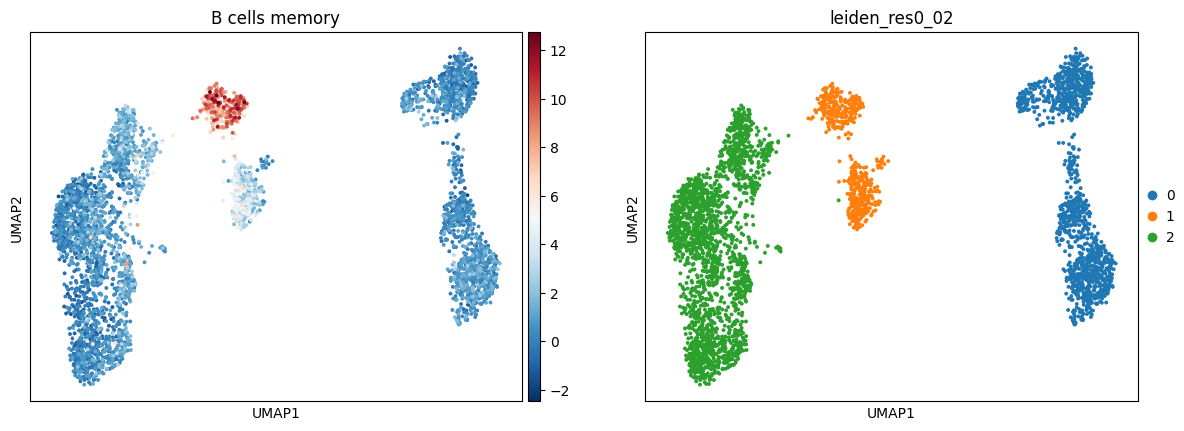

In [63]:
sc.pl.umap(score, color=["B cells memory", "leiden_res0_02"], cmap="RdBu_r")

In [64]:
import seaborn as sns

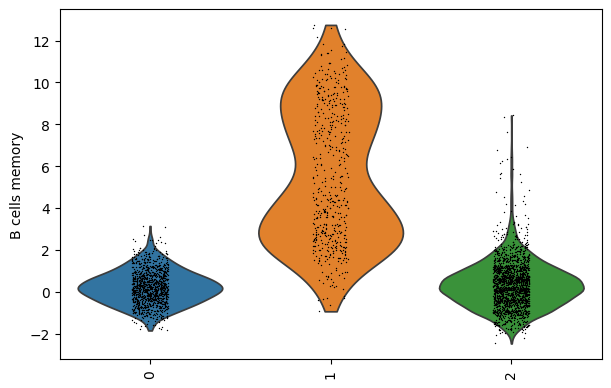

In [65]:
sc.pl.violin(score, keys=["B cells memory"], groupby="leiden_res0_02", rotation=90)

In [66]:
# Annotation
# Start with ranking the genes

# Create object score and copy clustering labels into it
# Copy the resolution 0.5 clustering results
score.obs['leiden_res2'] = bone_marrow_adata.obs['leiden_res2']

# Rank genes
# Find differential abundance of cell types between clusters
bone_marrow_rank = dc.tl.rankby_group(
    score,
    groupby="leiden",  # ← Changed from leiden_res0_02 to leiden_res0_5
    reference="rest",
    method="t-test_overestim_var"
)

# Filter to only include cell types with positive test statistic
bone_marrow_rank = bone_marrow_rank[bone_marrow_rank["stat"] > 0]

# Show top rows
bone_marrow_rank.head(15)  # Show more rows to see each cluster

,group,reference,name,stat,meanchange,pval,padj
0,0,rest,Alveolar macrophages,27.259406,3.876483,6.470020e-96,1.054613e-93
1,0,rest,Neutrophils,25.759761,4.978072,1.271304e-85,1.036113e-83
2,0,rest,Kupffer cells,24.486077,2.946141,7.873424e-85,4.277893e-83
3,0,rest,Monocytes,25.049818,7.793893,4.766713e-76,1.942436e-74
4,0,rest,Macrophages,22.500505,4.425569,4.286507e-71,1.397401e-69
5,0,rest,Fibroblasts,19.998589,2.136048,1.849551e-64,5.024614e-63
6,0,rest,Dendritic cells,20.994576,3.852728,3.527424e-63,8.213859e-62
7,0,rest,Satellite glial cells,18.892872,1.938003,6.114492e-61,1.245828e-59
8,0,rest,Microglia,19.579530,2.871289,7.510377e-61,1.360213e-59
9,0,rest,Leydig cells,17.863292,1.237677,6.314736e-56,1.029302e-54


In [67]:
#annotation

#start with ranking the genes
# Create object score and copy clustering labels into it
# Assuming 'score' is your ULM results object from earlier
#score.obs['leiden_res0_02'] = bone_marrow_adata.obs['leiden_res0_02']

# Rank genes
# Find differential abundance of cell types between clusters
#bone_marrow_rank = dc.tl.rankby_group(
    #score,
    #groupby="leiden_res0_02",
    #reference="rest",
    #method="t-test_overestim_var"
#)

# Filter to only include cell types with positive test statistic
#bone_marrow_rank = bone_marrow_rank[bone_marrow_rank["stat"] > 0]

# Show top rows
#bone_marrow_rank.head(10)

/tmp/ipython-input-4137258864.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_annotations = bone_marrow_rank.groupby("group").head(1).set_index("group")["name"].to_dict()


{'0': 'Alveolar macrophages', '1': 'B cells memory', '2': 'T memory cells', '3': 'NK cells', '4': 'Plasma cells', '5': 'T cells', '7': 'T cytotoxic cells', '6': 'T cytotoxic cells', '8': 'Gamma delta T cells', '9': 'T memory cells', '10': 'Monocytes', '11': 'Alveolar macrophages', '12': 'NK cells', '13': 'Platelets', '14': 'Epiblast cells', '15': 'Monocytes'}


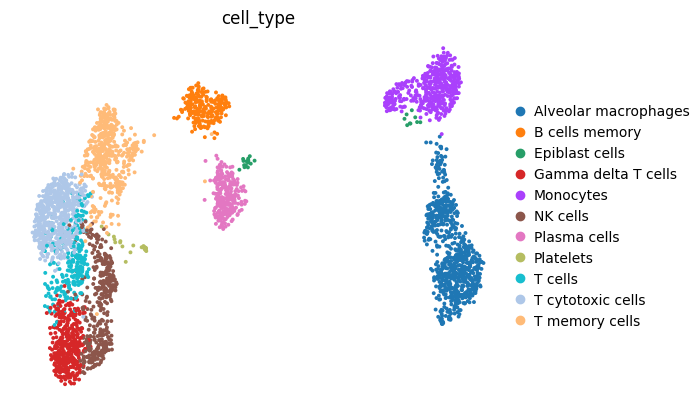

In [68]:
# Step 1: Copy clustering to score object
score.obs['leiden_res2'] = bone_marrow_adata.obs['leiden_res2']

# Step 2: Rank cell types for each cluster
bone_marrow_rank = dc.tl.rankby_group(
    score,
    groupby="leiden_res2",  # ← Use leiden_res2 (matching your column name)
    reference="rest",
    method="t-test_overestim_var"
)

# Step 3: Filter for positive statistics
bone_marrow_rank = bone_marrow_rank[bone_marrow_rank["stat"] > 0]

# Step 4: Look at results
bone_marrow_rank.head(20)

# Step 5: Create cluster annotations automatically
cluster_annotations = bone_marrow_rank.groupby("group").head(1).set_index("group")["name"].to_dict()

# Step 6: Check what was created
print(cluster_annotations)

# Step 7: Apply annotations
bone_marrow_adata.obs['cell_type'] = bone_marrow_adata.obs['leiden_res2'].map(cluster_annotations)

# Step 8: Visualize annotated clusters
sc.pl.umap(bone_marrow_adata, color='cell_type', legend_loc='right margin', frameon=False)

In [69]:
# Check how many clusters got annotations
print("Total clusters:", bone_marrow_adata.obs['leiden_res2'].nunique())
print("Annotated cell types:", bone_marrow_adata.obs['cell_type'].nunique())

# Check if any clusters are missing annotations (NaN values)
missing = bone_marrow_adata.obs['cell_type'].isna().sum()
print(f"Cells without annotation: {missing}")

# See which clusters got which cell types
cluster_to_celltype = bone_marrow_adata.obs.groupby('leiden_res2')['cell_type'].first()
print("\nCluster → Cell Type mapping:")
print(cluster_to_celltype)

# Count cells per cell type
print("\nCells per cell type:")
print(bone_marrow_adata.obs['cell_type'].value_counts())

Total clusters: 16
Annotated cell types: 11
Cells without annotation: 0

Cluster → Cell Type mapping:
leiden_res2
0     Alveolar macrophages
1           B cells memory
2           T memory cells
3                 NK cells
4             Plasma cells
5                  T cells
6        T cytotoxic cells
7        T cytotoxic cells
8      Gamma delta T cells
9           T memory cells
10               Monocytes
11    Alveolar macrophages
12                NK cells
13               Platelets
14          Epiblast cells
15               Monocytes
Name: cell_type, dtype: category
Categories (11, object): ['Alveolar macrophages', 'B cells memory', 'Epiblast cells', 'Gamma delta T cells',
                          ..., 'Platelets', 'T cells', 'T cytotoxic cells',
                          'T memory cells']

Cells per cell type:
cell_type
Alveolar macrophages    749
T cytotoxic cells       584
Monocytes               462
T memory cells          458
Gamma delta T cells     399
NK cells            

/tmp/ipython-input-3898461731.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_to_celltype = bone_marrow_adata.obs.groupby('leiden_res2')['cell_type'].first()


In [70]:
# Get available genes
available_genes = set(bone_marrow_adata.var_names)

#  Extract markers for each cell type

# Alveolar macrophages
alveolar_macro_markers = markers[markers['source'].isin(['Alveolar macrophages'])]['target']
alveolar_macro_markers = alveolar_macro_markers[alveolar_macro_markers.isin(available_genes)]

# B cells memory
b_cell_memory_markers = markers[markers['source'].isin(['B cells memory'])]['target']
b_cell_memory_markers = b_cell_memory_markers[b_cell_memory_markers.isin(available_genes)]

# Epiblast cells
epiblast_markers = markers[markers['source'].isin(['Epiblast cells'])]['target']
epiblast_markers = epiblast_markers[epiblast_markers.isin(available_genes)]

# Gamma delta T cells
gamma_delta_markers = markers[markers['source'].isin(['Gamma delta T cells'])]['target']
gamma_delta_markers = gamma_delta_markers[gamma_delta_markers.isin(available_genes)]

# Monocytes
monocyte_markers = markers[markers['source'].isin(['Monocytes'])]['target']
monocyte_markers = monocyte_markers[monocyte_markers.isin(available_genes)]

# NK cells
nk_markers = markers[markers['source'].isin(['NK cells'])]['target']
nk_markers = nk_markers[nk_markers.isin(available_genes)]

# Plasma cells
plasma_markers = markers[markers['source'].isin(['Plasma cells'])]['target']
plasma_markers = plasma_markers[plasma_markers.isin(available_genes)]

# Platelets
platelet_markers = markers[markers['source'].isin(['Platelets'])]['target']
platelet_markers = platelet_markers[platelet_markers.isin(available_genes)]

# T cells
t_cell_markers = markers[markers['source'].isin(['T cells'])]['target']
t_cell_markers = t_cell_markers[t_cell_markers.isin(available_genes)]

# T cytotoxic cells
t_cytotoxic_markers = markers[markers['source'].isin(['T cytotoxic cells'])]['target']
t_cytotoxic_markers = t_cytotoxic_markers[t_cytotoxic_markers.isin(available_genes)]

# T memory cells
t_memory_markers = markers[markers['source'].isin(['T memory cells'])]['target']
t_memory_markers = t_memory_markers[t_memory_markers.isin(available_genes)]

# Step 3: Check how many markers found for each
print("Markers found:")
print(f"Alveolar macrophages: {len(alveolar_macro_markers)}")
print(f"B cells memory: {len(b_cell_memory_markers)}")
print(f"Epiblast cells: {len(epiblast_markers)}")
print(f"Gamma delta T cells: {len(gamma_delta_markers)}")
print(f"Monocytes: {len(monocyte_markers)}")
print(f"NK cells: {len(nk_markers)}")
print(f"Plasma cells: {len(plasma_markers)}")
print(f"Platelets: {len(platelet_markers)}")
print(f"T cells: {len(t_cell_markers)}")
print(f"T cytotoxic cells: {len(t_cytotoxic_markers)}")
print(f"T memory cells: {len(t_memory_markers)}")

Markers found:
Alveolar macrophages: 22
B cells memory: 58
Epiblast cells: 6
Gamma delta T cells: 50
Monocytes: 95
NK cells: 77
Plasma cells: 72
Platelets: 124
T cells: 87
T cytotoxic cells: 8
T memory cells: 56


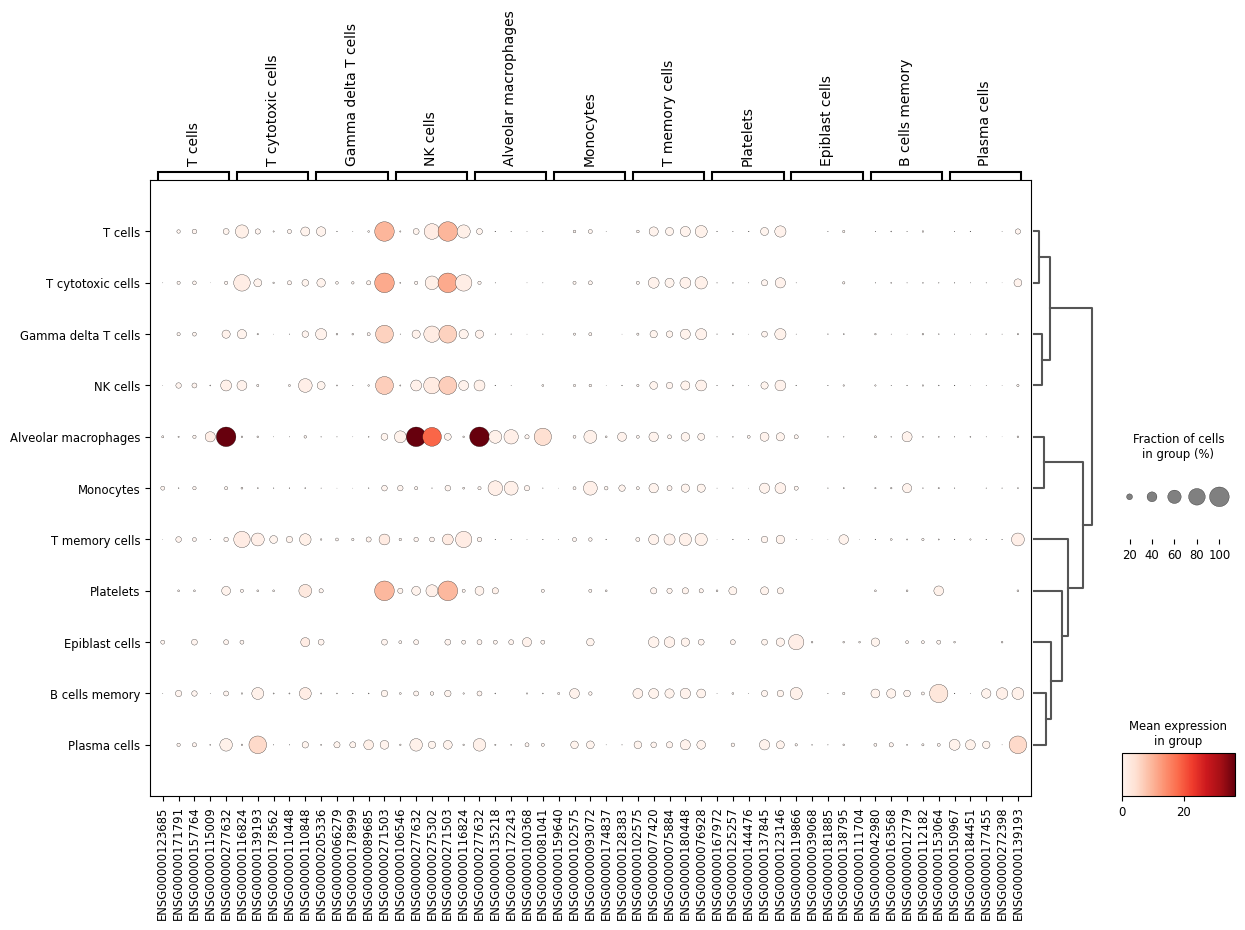

In [71]:
# Create marker genes dictionary with top 5 markers for each cell type
marker_genes_dict = {
    "Alveolar macrophages": alveolar_macro_markers.head(5).tolist(),
    "B cells memory": b_cell_memory_markers.head(5).tolist(),
    "Epiblast cells": epiblast_markers.head(5).tolist(),
    "Gamma delta T cells": gamma_delta_markers.head(5).tolist(),
    "Monocytes": monocyte_markers.head(5).tolist(),
    "NK cells": nk_markers.head(5).tolist(),
    "Plasma cells": plasma_markers.head(5).tolist(),
    "Platelets": platelet_markers.head(5).tolist(),
    "T cells": t_cell_markers.head(5).tolist(),
    "T cytotoxic cells": t_cytotoxic_markers.head(5).tolist(),
    "T memory cells": t_memory_markers.head(5).tolist()
}

# Create dot plot
sc.pl.dotplot(
    bone_marrow_adata,
    marker_genes_dict,
    groupby='cell_type',
    dendrogram=True,
    figsize=(14, 8)
)

In [73]:
cell_counts = bone_marrow_adata.obs['cell_type'].value_counts()
cell_proportions = (cell_counts / cell_counts.sum() * 100).round(2)
print(cell_proportions)

cell_type
Alveolar macrophages    19.72
T cytotoxic cells       15.37
Monocytes               12.16
T memory cells          12.06
Gamma delta T cells     10.50
NK cells                 9.98
Plasma cells             6.79
T cells                  6.11
B cells memory           6.05
Epiblast cells           0.66
Platelets                0.61
Name: count, dtype: float64
